# Plasmodium data

This notebook was designed to read and analyze the `.dv` *(deltavision)* files. In our case these files contain time-series frames of plasmodium.

### What does this notebook do?  
1. First, it traverses through all directories and subdirectories in the current directory and finds all the `.dv` files.
   - A list of the file paths is stored in the variable `dv_files`.
   - A dropdown menu is created from the list of files and is then shown to the user.
2. User can select the desired file via a dropdown menu.
3. After a file is selected, a 2-row by 4-column plot shows up. The plot contains:
   1. First column: the captured frame of plasmodium at time `t`.
   2. The rest of the columns: the line plot of the **minimum, average, and maximum pixel intensity** of the frame at time `t` in the same order.

### Some notes about the data
1. The data was huge and I had to exclude them from the `data` directory. But you can and should add your directories containing the `.dv` files under the `data` directory.
2. Upon examining the header of the files I realized that there are **two channels** of **41 frames** in each `.dv` file. Hence the 2-row-plot. Each row of the plot corresponds to a channel in the `.dv. file.
3. The `.dv` file has a header containing a great deal of useful information. The enum class `headerTuples` was created to make it easier and more human readabla to extract the desired header value. I.e. instead of 

In [1]:
# Some imports.

from enum import Enum
import os
import warnings

import dash
from dash import dcc
from dash import html
from IPython.display import display, clear_output
import cv2
from ipywidgets import interact, interact_manual, widgets, Dropdown
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageStat
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from mrc import DVFile, imread

%matplotlib inline

In [2]:
# Configuration.

data_root = ""

In [3]:
def find_dv_files(parent_dir: str) -> list[str]:
    """
    Given a root directory, this function traverses it recursively to find any 
    files ending in .dv and returns them as a list of absolute file URIs.
    """
    dv_files = []
    for root, dirs, files in os.walk(parent_dir, topdown=False):
        for name in files:
            _, ext = os.path.splitext(name)
            if ext == '.dv':
                dv_files.append(os.path.join(root, name))
    return dv_files

class headerTuples(Enum):
    photosensorReading = 0
    timeStampSeconds = 1
    stageXCoord = 2
    stageYCoord = 3
    stageZCoord = 4
    minInten = 5
    maxInten = 6
    meanInten = 7
    expTime = 8
    ndFilter = 9
    exWavelen = 10
    emWavelen = 11
    intenScaling = 12
    energyConvFactor = 13


def read_as_nparray(filename: str):
    img_array = imread(filename)
    assert len(
        img_array) > 0, f"file {filename} is not a valid DV file or is corrupted."
    return img_array


def save_nparray_image_as_png(nparray_image: np.ndarray, directory: str, filename: str):
    assert len(
        nparray_image.shape) == 2, "pass one image at a time. e.g. a 500 by 500 array"
    imageio.imwrite(f"{filename}.png", nparray_image)

def load_dv_file(file_name):
    return DVFile(file_name)


def get_intensities(dv_img, type: str = 'mean'):
    intensities = []
    for i in range(81):
        if type == 'mean':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.meanInten.value])
        if type == 'min':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.minInten.value])
        if type == 'max':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.maxInten.value])
    return intensities


def get_dv_data(img: DVFile):
    return img.asarray()


In [ ]:
def draw(data_dir):

    @interact
    def brows_files(filename=widgets.Dropdown(options=find_dv_files(data_dir), description="select file"), i=widgets.IntSlider(min=0, max=40, step=1, value=0)):
        dv_file = load_dv_file(filename)
        image = get_dv_data(dv_file)
        n = image.shape[1] - 1 if image is not None else 40
        all_frames = np.ndarray((82, 960, 960))
        all_frames = np.concatenate((image[0], image[1]))
        avgIntensities = []
        minIntensities = []
        maxIntensities = []
        avgIntensities = get_intensities(dv_file, 'mean')
        minIntensities = get_intensities(dv_file, 'min')
        maxIntensities = get_intensities(dv_file, 'max')

        # def mean(i, j): return np.mean(image[i, j])

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        calcMeanIntens = []
        for j in range(len(all_frames)):
            calcMeanIntens.append(np.mean(all_frames[j]))

        calcMinIntens = []
        for j in range(len(all_frames)):
            calcMinIntens.append(np.min(all_frames[j]))

        calcMaxIntens = []
        for j in range(len(all_frames)):
            calcMaxIntens.append(np.max(all_frames[j]))

        axs[0, 0].imshow(image[0, i], cmap=plt.cm.gray_r,
                         interpolation='nearest')
        axs[1, 0].imshow(image[1, i], cmap=plt.cm.gray_r,
                         interpolation='nearest')

        axs[0, 1].plot(minIntensities[:n])
        axs[0, 1].plot(calcMinIntens[:n])
        axs[0, 1].plot(i, minIntensities[i], 'go')
        axs[1, 1].plot(minIntensities[n+1:])
        axs[1, 1].plot(calcMinIntens[n+1:])
        axs[1, 1].plot(i, minIntensities[n+1+i], 'go')
        axs[0, 1].set_title("minimum pixel intensity")

        axs[0, 2].plot(avgIntensities[:n])
        axs[0, 2].plot(calcMeanIntens[:n])
        axs[0, 2].plot(i, avgIntensities[i], 'go')
        axs[1, 2].plot(avgIntensities[n+1:])
        axs[1, 2].plot(calcMeanIntens[n+1:])
        axs[1, 2].plot(i, avgIntensities[n+1+i], 'go')

        axs[0, 2].set_title("average pixel intensity")

        axs[0, 3].plot(maxIntensities[:n])
        axs[0, 3].plot(calcMaxIntens[:n])
        axs[0, 3].plot(i, maxIntensities[i], 'go')
        axs[1, 3].plot(maxIntensities[n+1:])
        axs[1, 3].plot(calcMaxIntens[n+1:])
        axs[1, 3].plot(i, maxIntensities[n+1+i], 'go')
        axs[0, 3].set_title("maximum pixel intensity")

        fig.tight_layout()

draw(data_root)

In [14]:
# Let's walk through it here.
dv_files = find_dv_files(data_root)
controls = list(filter(lambda x: x.find("Control") >= 0, dv_files))
mutants = list(filter(lambda x: x.find("Control") < 0, dv_files))

In [10]:
# Load the first one.
dv_file = load_dv_file(dv_files[0])
image = get_dv_data(dv_file)
print(image.shape)

(2, 41, 960, 960)


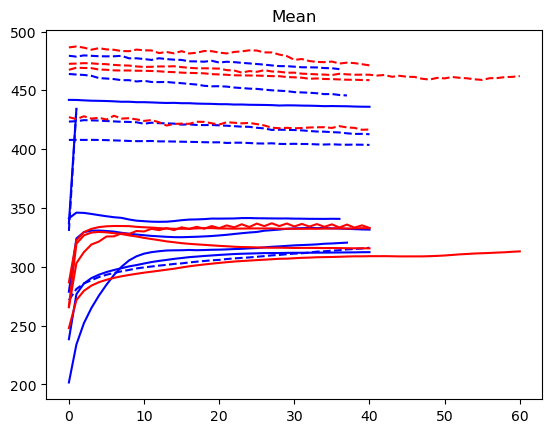

In [24]:
plt.figure(0)
plt.title("Mean")
for c in controls:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(img[0].mean(axis = (1, 2)), 'b-')
    plt.plot(img[1].mean(axis = (1, 2)), 'b--')
    
for c in mutants:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(img[0].mean(axis = (1, 2)), 'r-')
    plt.plot(img[1].mean(axis = (1, 2)), 'r--')

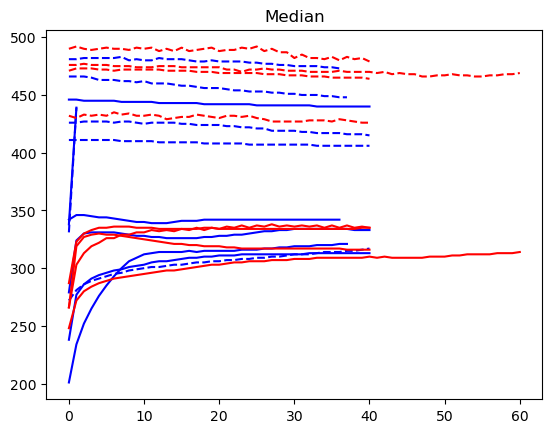

In [25]:
plt.figure(1)
plt.title("Median")
for c in controls:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(np.median(img[0], axis = (1, 2)), 'b-')
    plt.plot(np.median(img[1], axis = (1, 2)), 'b--')
    
for c in mutants:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(np.median(img[0], axis = (1, 2)), 'r-')
    plt.plot(np.median(img[1], axis = (1, 2)), 'r--')

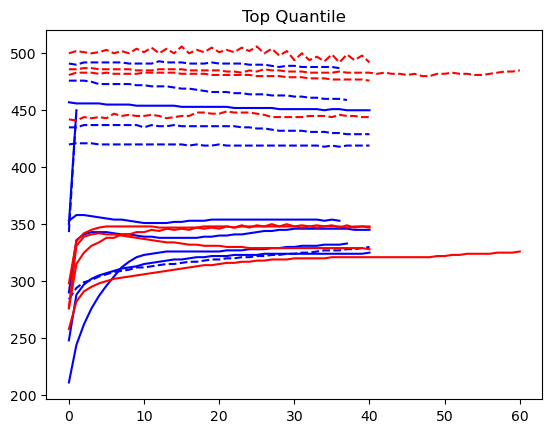

In [28]:
plt.figure(1)
plt.title("Top Quantile")
for c in controls:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(np.quantile(img[0], 0.75, axis = (1, 2)), 'b-')
    plt.plot(np.quantile(img[1], 0.75, axis = (1, 2)), 'b--')
    
for c in mutants:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.plot(np.quantile(img[0], 0.75, axis = (1, 2)), 'r-')
    plt.plot(np.quantile(img[1], 0.75, axis = (1, 2)), 'r--')

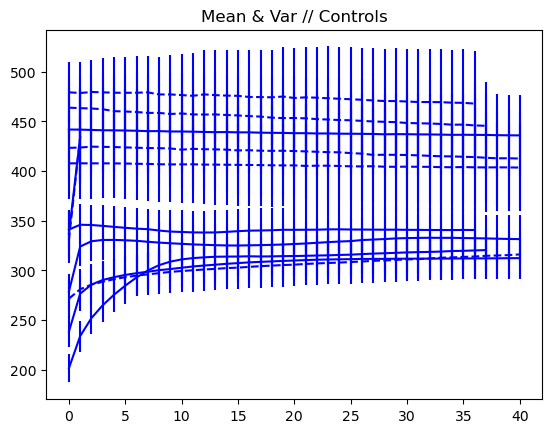

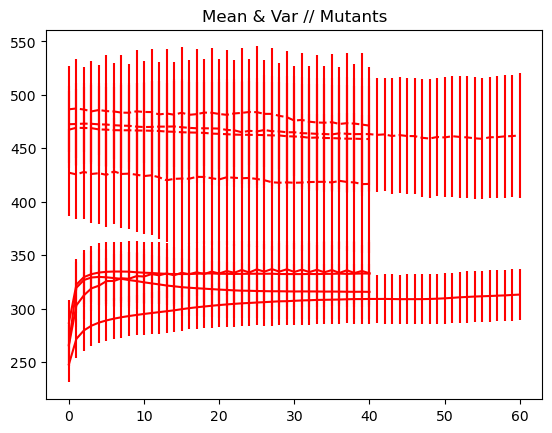

In [35]:
plt.figure(3)
plt.title("Mean & Var // Controls")
for c in controls:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.errorbar(x = np.arange(img[0].shape[0]), y = img[0].mean(axis = (1, 2)), yerr = img[0].std(axis = (1, 2)), c = 'b', ls = '-')
    plt.errorbar(x = np.arange(img[1].shape[0]), y = img[1].mean(axis = (1, 2)), yerr = img[1].std(axis = (1, 2)), c = 'b', ls = '--')

plt.figure(4)
plt.title("Mean & Var // Mutants")
for c in mutants:
    dv = load_dv_file(c)
    img = get_dv_data(dv)
    
    plt.errorbar(x = np.arange(img[0].shape[0]), y = img[0].mean(axis = (1, 2)), yerr = img[0].std(axis = (1, 2)), c = 'r', ls = '-')
    plt.errorbar(x = np.arange(img[1].shape[0]), y = img[1].mean(axis = (1, 2)), yerr = img[1].std(axis = (1, 2)), c = 'r', ls = '--')